# libraries

In [1]:
#pip install torchmetrics

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [3]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torchmetrics.regression import MeanAbsolutePercentageError
import time

C:\Users\User\conda3\envs\diploma\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"

In [5]:
device

device(type='cuda')

In [6]:
torch.cuda.memory_allocated()

0

In [7]:
torch.cuda.empty_cache()

# settings

In [8]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # otherwise plt kills kernel :(

# check data

In [9]:
data = pd.read_csv("Metro_Traffic_Volume.csv")

In [10]:
data

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
48199,NaN,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,NaN,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,NaN,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,NaN,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450


In [11]:
data.holiday.value_counts()

holiday
Labor Day                    7
Thanksgiving Day             6
Christmas Day                6
New Years Day                6
Martin Luther King Jr Day    6
Columbus Day                 5
Veterans Day                 5
Washingtons Birthday         5
Memorial Day                 5
Independence Day             5
State Fair                   5
Name: count, dtype: int64

In [12]:
data.weather_main.value_counts()

weather_main
Clouds          15164
Clear           13391
Mist             5950
Rain             5672
Snow             2876
Drizzle          1821
Haze             1360
Thunderstorm     1034
Fog               912
Smoke              20
Squall              4
Name: count, dtype: int64

In [13]:
data.weather_description.value_counts()

weather_description
sky is clear                           11665
mist                                    5950
overcast clouds                         5081
broken clouds                           4666
scattered clouds                        3461
light rain                              3372
few clouds                              1956
light snow                              1946
Sky is Clear                            1726
moderate rain                           1664
haze                                    1360
light intensity drizzle                 1100
fog                                      912
proximity thunderstorm                   673
drizzle                                  651
heavy snow                               616
heavy intensity rain                     467
snow                                     293
proximity shower rain                    136
thunderstorm                             125
heavy intensity drizzle                   64
thunderstorm with heavy rain       

In [14]:
data.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


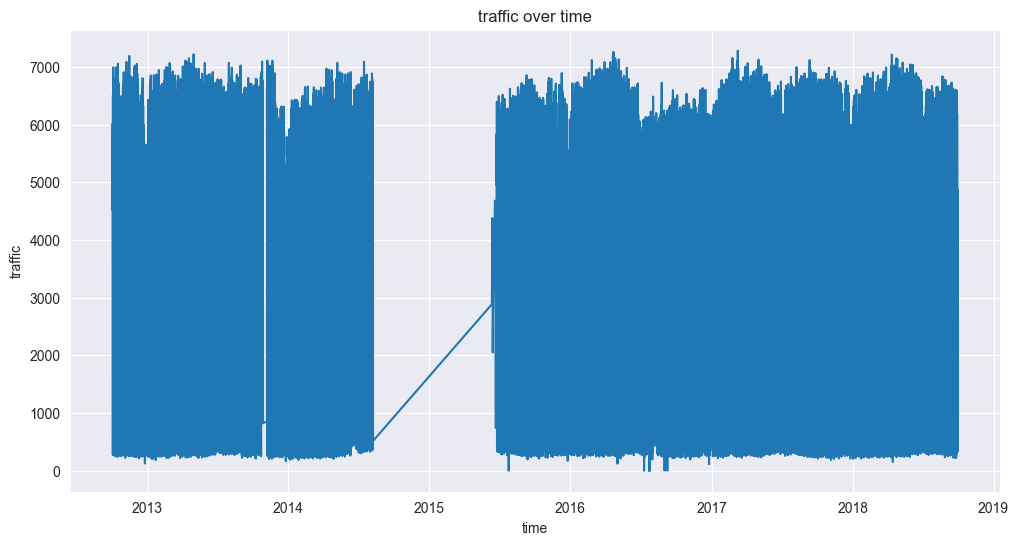

In [15]:
data['date_time'] = pd.to_datetime(data['date_time'])
plt.figure(figsize=(12, 6))
sns.lineplot(x='date_time', y='traffic_volume', data=data)
plt.title('traffic over time')
plt.xlabel('time')
plt.ylabel('traffic')
plt.show()

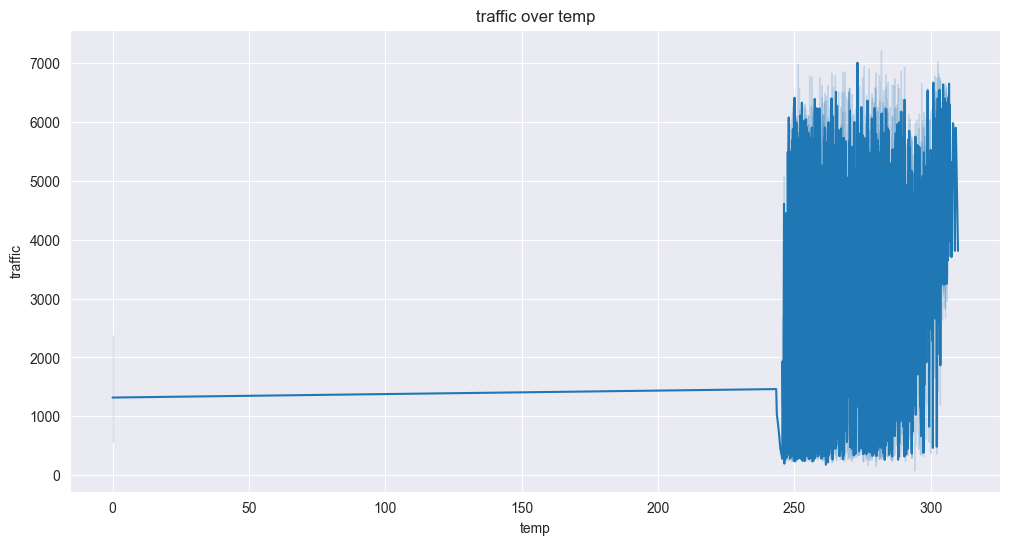

In [16]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='temp', y='traffic_volume', data=data)
plt.title('traffic over temp')
plt.xlabel('temp')
plt.ylabel('traffic')
plt.show()

In [17]:
data.temp.value_counts()

temp
274.150    128
275.150     89
274.080     85
276.793     78
291.150     73
          ... 
260.970      1
277.240      1
270.190      1
282.190      1
304.900      1
Name: count, Length: 5843, dtype: int64

In [18]:
len(data)

48204

In [19]:
data = data.loc[data['temp'] > 245]

In [20]:
len(data)

48187

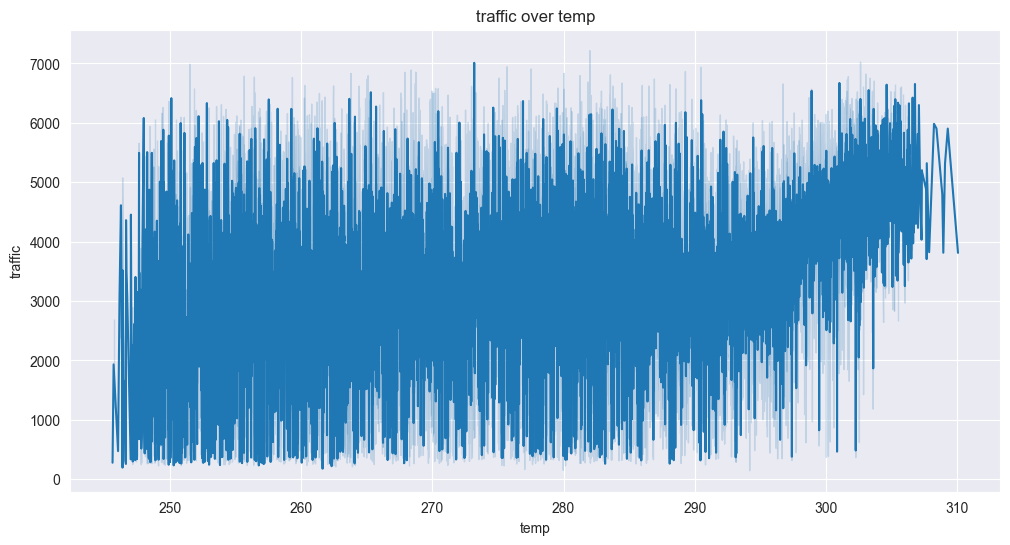

In [21]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='temp', y='traffic_volume', data=data)
plt.title('traffic over temp')
plt.xlabel('temp')
plt.ylabel('traffic')
plt.show()

In [22]:
len(data.loc[data.temp > 300])

1863

In [23]:
len(data.loc[data.rain_1h > 0])

3467

In [24]:
len(data.loc[data.snow_1h > 0])

63

so, after looking at all the data that I wanted, I think there will be 3 tests with shifts.
1. shift by date (although everything doesn’t change much there, but by date I’ll do it anyway)
2. temperature shift
3. rain shift 

about the shift, I mean that the neural network will not see data on the presence of rain and it will be very interesting how it will react when there is a sudden shift in rain or temperature

# data process

In [9]:
df = pd.read_csv("Metro_Traffic_Volume.csv")

In [10]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [11]:
df.weather_description.unique()

array(['scattered clouds', 'broken clouds', 'overcast clouds',
       'sky is clear', 'few clouds', 'light rain',
       'light intensity drizzle', 'mist', 'haze', 'fog',
       'proximity shower rain', 'drizzle', 'moderate rain',
       'heavy intensity rain', 'proximity thunderstorm',
       'thunderstorm with light rain', 'proximity thunderstorm with rain',
       'heavy snow', 'heavy intensity drizzle', 'snow',
       'thunderstorm with heavy rain', 'freezing rain', 'shower snow',
       'light rain and snow', 'light intensity shower rain', 'SQUALLS',
       'thunderstorm with rain', 'proximity thunderstorm with drizzle',
       'thunderstorm', 'Sky is Clear', 'very heavy rain',
       'thunderstorm with light drizzle', 'light snow',
       'thunderstorm with drizzle', 'smoke', 'shower drizzle',
       'light shower snow', 'sleet'], dtype=object)

In [12]:
df.weather_main.unique()

array(['Clouds', 'Clear', 'Rain', 'Drizzle', 'Mist', 'Haze', 'Fog',
       'Thunderstorm', 'Snow', 'Squall', 'Smoke'], dtype=object)

let's add all taxonomy levels to the data

In [13]:
def return_val_traffic(val):
    if (val < 600):
        return 0, 0
    elif (val >= 600 and val <= 1200):
        return 0, 1
    elif (val > 1200 and val < 3000):
        return 1, 2    
    elif (val >= 3000 and val <= 4900):
        return 1, 3
    elif (val > 4900 and val < 5900):
        return 2, 4
    elif (val >= 5900):
        return 2, 5

In [14]:
def return_weather_main(val):
    if (val == 'Clouds' or val == 'Clear'):
        return 0
    else:
        return 1

In [15]:
clear = ['Sky is Clear', 'sky is clear']
clouds = ['scattered clouds', 'broken clouds', 'overcast clouds', 'few clouds']
rain = ['light rain', 'light intensity drizzle', 'mist', 'haze', 'fog', 'proximity shower rain', 'drizzle', \
        'moderate rain', 'heavy intensity rain', 'heavy intensity drizzle', 'shower drizzle', 'very heavy rain', \
        'light rain and snow', 'light intensity shower rain', 'freezing rain', 'shower snow']
        
snow = ['light snow', 'light shower snow', 'sleet', 'heavy snow', 'snow']
def return_weather_desc(val):
    if (val in clear):
        return 0
    elif (val in clouds):
        return 1
    elif (val in rain):
        return 2
    elif (val in snow):
        return 3
    else:
        return 4

In [16]:
# traffic_1 from 0 to 2 (3 values)
# traffic_2 from 0 to 5 (6 values)

# weather_1 from 0 to 1 (2 values)
# weather_2 from 0 to 4 (5 values)
def adding_taxonomy(row):    
    traffic_1, traffic_2 = return_val_traffic(row['traffic_volume'])
    weather_1 = return_weather_main(row['weather_main'])
    weather_2 = return_weather_desc(row['weather_description'])
        
    return traffic_1, traffic_2, weather_1, weather_2

In [17]:
%%time
df['traffic_1'], df['traffic_2'], df['weather_1'], df['weather_2'] = zip(*df.apply(adding_taxonomy, axis=1))

CPU times: total: 438 ms
Wall time: 857 ms


In [18]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,traffic_1,traffic_2,weather_1,weather_2
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,2,4,0,1
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,1,3,0,1
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,1,3,0,1
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026,2,4,0,1
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918,2,4,0,1


so, we have implemented 2 taxonomies in the training data, now we can move on to further data processing.

let's move on to encoding the weather and holidays

In [19]:
weather_desc_keys = df.weather_description.unique()
holiday_keys = df.holiday.unique()
weather_main_keys = df.weather_main.unique()

In [20]:
holiday_keys

array([nan, 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
       'Martin Luther King Jr Day'], dtype=object)

In [21]:
dict_weather_desc = dict(zip(weather_desc_keys, [i for i in range(len(weather_desc_keys))]))
dict_holiday = dict(zip(holiday_keys, [i for i in range(len(holiday_keys))]))
dict_weather_main = dict(zip(weather_main_keys, [i for i in range(len(weather_main_keys))]))

In [22]:
dict_holiday

{nan: 0,
 'Columbus Day': 1,
 'Veterans Day': 2,
 'Thanksgiving Day': 3,
 'Christmas Day': 4,
 'New Years Day': 5,
 'Washingtons Birthday': 6,
 'Memorial Day': 7,
 'Independence Day': 8,
 'State Fair': 9,
 'Labor Day': 10,
 'Martin Luther King Jr Day': 11}

In [23]:
def encode(row):
    holiday_encoded = dict_holiday[row['holiday']]
    weather_main_encoded = dict_weather_main[row['weather_main']]
    weather_desc_encoded = dict_weather_desc[row['weather_description']]
    return holiday_encoded, weather_main_encoded, weather_desc_encoded

In [24]:
%%time
df['holiday'], df['weather_main'], df['weather_description'] = zip(*df.apply(encode, axis=1))

CPU times: total: 297 ms
Wall time: 482 ms


In [25]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,traffic_1,traffic_2,weather_1,weather_2
0,0,288.28,0.0,0.0,40,0,0,2012-10-02 09:00:00,5545,2,4,0,1
1,0,289.36,0.0,0.0,75,0,1,2012-10-02 10:00:00,4516,1,3,0,1
2,0,289.58,0.0,0.0,90,0,2,2012-10-02 11:00:00,4767,1,3,0,1
3,0,290.13,0.0,0.0,90,0,2,2012-10-02 12:00:00,5026,2,4,0,1
4,0,291.14,0.0,0.0,75,0,1,2012-10-02 13:00:00,4918,2,4,0,1


now we need to somehow convert the date only to the year

In [26]:
df['date_time'] = pd.to_datetime(df['date_time'])

In [27]:
df["year"] = df["date_time"].dt.to_period("Y")
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,traffic_1,traffic_2,weather_1,weather_2,year
0,0,288.28,0.0,0.0,40,0,0,2012-10-02 09:00:00,5545,2,4,0,1,2012
1,0,289.36,0.0,0.0,75,0,1,2012-10-02 10:00:00,4516,1,3,0,1,2012
2,0,289.58,0.0,0.0,90,0,2,2012-10-02 11:00:00,4767,1,3,0,1,2012
3,0,290.13,0.0,0.0,90,0,2,2012-10-02 12:00:00,5026,2,4,0,1,2012
4,0,291.14,0.0,0.0,75,0,1,2012-10-02 13:00:00,4918,2,4,0,1,2012


In [28]:
df = df.drop('date_time', axis=1)

In [29]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,traffic_1,traffic_2,weather_1,weather_2,year
0,0,288.28,0.0,0.0,40,0,0,5545,2,4,0,1,2012
1,0,289.36,0.0,0.0,75,0,1,4516,1,3,0,1,2012
2,0,289.58,0.0,0.0,90,0,2,4767,1,3,0,1,2012
3,0,290.13,0.0,0.0,90,0,2,5026,2,4,0,1,2012
4,0,291.14,0.0,0.0,75,0,1,4918,2,4,0,1,2012


In [36]:
df.year = df.year.astype(str)

In [37]:
df.year = df.year.astype(int)

we have fully prepared the data, we can move on

In [42]:
df.to_csv('TRAFFIC_data.csv', index=False)

# introduction:
before we start, I want to say that several taxonomies will be built and also for each of them several shifts

## taxonomy

### 1st by traffic 
for traffic we can introduce the following taxonomy:

1. little traffic: ***<font color="green">val</font><1200***
    - very small: ***<font color="green">val</font><600***
    - small: ***600<<font color="green">val</font><1200***
2. average: ***1200<<font color="green">val</font><4900***
    - less than average: ***1200<<font color="green">val</font><3000***
    - greater than average: ***3000<<font color="green">val</font><4900***
3. many: ***<font color="green">val</font>>4900***
    - many: ***4900<<font color="green">val</font><5900***
    - very much: ***<font color="green">val</font>>5900***
  
### 2nd by weather
for hz we can introduce the following taxonomy:
1. weather main:
    - good (clouds, clear)
    - bad (other types)
2. weather description:
    - clouds
    - clear
    - rain
    - snow
    - extreme

### 3rd could be based on weather conditions and time of day
but i have no time to do it

## shifts

- by temp: val > 295
- by year: val >= 2018
- by rain_1h: val > 0

# NN learning

In [9]:
df = pd.read_csv('TRAFFIC_data.csv')
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,traffic_1,traffic_2,weather_1,weather_2,year
0,0,288.28,0.0,0.0,40,0,0,5545,2,4,0,1,2012
1,0,289.36,0.0,0.0,75,0,1,4516,1,3,0,1,2012
2,0,289.58,0.0,0.0,90,0,2,4767,1,3,0,1,2012
3,0,290.13,0.0,0.0,90,0,2,5026,2,4,0,1,2012
4,0,291.14,0.0,0.0,75,0,1,4918,2,4,0,1,2012


## some functions

In [10]:
class TorchStandardScaler:
  def fit(self, x):
    self.mean = x.mean(0)
    self.std = x.std(0)
  def transform(self, x):
    x -= self.mean
    x /= (self.std + 1e-7)
    return x

In [11]:
def make_graph(test_1, test_2, name, title="comparison"):
    epochs = [i*500 for i in range(len(test_1))]

    plt.plot(epochs, test_1, "g", label="loss with taxonomy")
    plt.plot(epochs, test_2, "r", label="loss without")

    plt.title(title)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    fig1 = plt.gcf()
    plt.semilogy()
    plt.show()

    fig1.savefig(name)

In [12]:
def make_graph_predicted(y_true, test_1, test_2, name, title="true vs predicted"):
    data_1, data_2, true = [], [], []
    for i in range(0, len(y_true), 100):
        data_1.append(test_1[i])
        data_2.append(test_2[i])
        true.append(y_true[i])
        
    length = [i for i in range(len(true))]

    plt.plot(length, true, "g", label="true", alpha=.7)
    plt.plot(length, data_1, "y", label="preicted with taxonomy", alpha=.7)
    plt.plot(length, data_2, "b", label="predicted without", alpha=.7)

    plt.title(title)
    plt.xlabel("data")
    plt.ylabel("traffic volume")
    plt.legend()
    fig1 = plt.gcf()
    plt.show()

    fig1.savefig(name)

In [13]:
def calculate_mean_difference(a1, a2):
    difference = 0
    for i in range(len(a1)):
        difference += abs(a1[i].item() - a2[i].item())
    print(difference/len(a1))

## taxonomy traffic

### model + some functions

In [14]:
class RegressionModelTraffic(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModelTraffic, self).__init__()
        self.hidden1 = nn.Linear(input_dim, 64)
        
        self.hidden2 = nn.Linear(64, 32)
        self.hidden2_out = nn.Linear(32, 3)
        
        self.hidden3 = nn.Linear(32, 16)
        
        self.hidden4 = nn.Linear(16, 8)
        self.hidden4_out = nn.Linear(8, 6)
        
        self.output = nn.Linear(8, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        
        x = self.relu(self.hidden2(x))
        x2_out = self.hidden2_out(x)
        
        x = self.relu(self.hidden3(x))
        
        x = self.relu(self.hidden4(x))
        x4_out = self.hidden4_out(x)
        
        output = self.output(x)
        return output, x2_out, x4_out

In [15]:
def trainModelTraffic(model, tax, num_epochs=1000, save_path='bestModel'):
    loss_val = []
    accuracy = []
    total_accu = None
    total_acc, total_count = 0, 0
    
    criterion_regression = nn.HuberLoss()
    criterion_classification = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_loss = float('inf')
    best_model_wts = model.state_dict()

    for epoch in range(num_epochs):
        model.train()
        
        outputs, x2_out, x4_out = model(X_train)
        loss = criterion_regression(outputs, y_train)

        loss_1 = criterion_classification(x2_out, traffic_1)*100
        loss_2 = criterion_classification(x4_out, traffic_2)*100

        if tax:
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
            
            optimizer.zero_grad()
            loss_1.backward(retain_graph=True)
            optimizer.step()
            
            optimizer.zero_grad()
            loss_2.backward(retain_graph=True)
            optimizer.step()
        else:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            predictions, _, _ = model(X_test)
            test_loss = criterion_regression(predictions, y_test)
        
        if test_loss < best_loss:
            best_loss = test_loss
            torch.save(model.state_dict(), save_path)
            #best_model_wts = model.state_dict()

        if (epoch+1) % 500 == 0:
            print(f'epoch {(epoch+1):6d}/{num_epochs:6d} | training Loss: {loss.item():.2f} | test Loss: {test_loss.item():10.2f}')
            loss_val.append(test_loss.cpu())
    
    model.load_state_dict(torch.load(save_path))
    model.eval()
    predictions, _, _ = model(X_test)
    loss = criterion_regression(predictions, y_test)
    print(f'\nBest loss: {loss.item():.2f}')
    
    return predictions, loss_val

### shift temp

In [16]:
shift_temp = df.copy()
shift_temp = shift_temp.drop(['year', 'weather_1', 'weather_2'], axis = 1)

shift_temp_train = shift_temp.loc[shift_temp['temp'] <= 295]
shift_temp_test = shift_temp.loc[shift_temp['temp'] > 295]

In [17]:
shift_temp_train.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,traffic_1,traffic_2
0,0,288.28,0.0,0.0,40,0,0,5545,2,4
1,0,289.36,0.0,0.0,75,0,1,4516,1,3
2,0,289.58,0.0,0.0,90,0,2,4767,1,3
3,0,290.13,0.0,0.0,90,0,2,5026,2,4
4,0,291.14,0.0,0.0,75,0,1,4918,2,4


In [18]:
traffic_train = shift_temp_train[['traffic_1', 'traffic_2']]
traffic_1 = traffic_train['traffic_1'].iloc[:].values
traffic_2 = traffic_train['traffic_2'].iloc[:].values

traffic_1 = torch.tensor(traffic_1, dtype=torch.float32).view(-1, 1).to(device)
traffic_2 = torch.tensor(traffic_2, dtype=torch.float32).view(-1, 1).to(device)

traffic_1 = traffic_1.flatten(end_dim=1).type(torch.LongTensor).to(device)
traffic_2 = traffic_2.flatten(end_dim=1).type(torch.LongTensor).to(device)

In [19]:
shift_temp_train = shift_temp_train.drop(['traffic_1', 'traffic_2'], axis=1)
shift_temp_test = shift_temp_test.drop(['traffic_1', 'traffic_2'], axis=1)
shift_temp_train.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
0,0,288.28,0.0,0.0,40,0,0,5545
1,0,289.36,0.0,0.0,75,0,1,4516
2,0,289.58,0.0,0.0,90,0,2,4767
3,0,290.13,0.0,0.0,90,0,2,5026
4,0,291.14,0.0,0.0,75,0,1,4918


In [20]:
X_train = shift_temp_train.drop('traffic_volume', axis=1)
y_train = shift_temp_train.traffic_volume
X_test = shift_temp_test.drop('traffic_volume', axis=1)
y_test = shift_temp_test.traffic_volume

data standardization

In [21]:
X_train = X_train.iloc[:, :].values
y_train = y_train.iloc[:].values
X_test = X_test.iloc[:, :].values
y_test = y_test.iloc[:].values

In [22]:
scaler = TorchStandardScaler()
scaler.fit(X_train)

In [23]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

converting data to tensors

In [24]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

training

In [25]:
input_dim = X_train.shape[1]
model = RegressionModelTraffic(input_dim).to(device)
model_wout = RegressionModelTraffic(input_dim).to(device)

In [26]:
%%time
pred_1, loss_1 = trainModelTraffic(model, True, 10000, 'models_2/bestModel_ShT_TaxTr')

epoch    500/ 10000 | training Loss: 1896.02 | test Loss:    1890.69
epoch   1000/ 10000 | training Loss: 1747.87 | test Loss:    1420.61
epoch   1500/ 10000 | training Loss: 1738.73 | test Loss:    1424.07
epoch   2000/ 10000 | training Loss: 1734.95 | test Loss:    1421.79
epoch   2500/ 10000 | training Loss: 1732.38 | test Loss:    1405.71
epoch   3000/ 10000 | training Loss: 1730.61 | test Loss:    1398.72
epoch   3500/ 10000 | training Loss: 1728.31 | test Loss:    1392.83
epoch   4000/ 10000 | training Loss: 1724.96 | test Loss:    1401.35
epoch   4500/ 10000 | training Loss: 1719.26 | test Loss:    1388.31
epoch   5000/ 10000 | training Loss: 1715.80 | test Loss:    1365.61
epoch   5500/ 10000 | training Loss: 1713.77 | test Loss:    1355.07
epoch   6000/ 10000 | training Loss: 1712.05 | test Loss:    1353.30
epoch   6500/ 10000 | training Loss: 1710.40 | test Loss:    1344.30
epoch   7000/ 10000 | training Loss: 1708.19 | test Loss:    1328.26
epoch   7500/ 10000 | training Los

In [27]:
%%time
pred_2, loss_2 = trainModelTraffic(model_wout, False, 10000, 'models_2/bestModel_ShT_TaxTr___old')

epoch    500/ 10000 | training Loss: 1752.66 | test Loss:    1433.40
epoch   1000/ 10000 | training Loss: 1731.14 | test Loss:    1406.58
epoch   1500/ 10000 | training Loss: 1720.93 | test Loss:    1434.63
epoch   2000/ 10000 | training Loss: 1714.87 | test Loss:    1429.74
epoch   2500/ 10000 | training Loss: 1710.96 | test Loss:    1425.46
epoch   3000/ 10000 | training Loss: 1706.35 | test Loss:    1408.81
epoch   3500/ 10000 | training Loss: 1701.54 | test Loss:    1417.57
epoch   4000/ 10000 | training Loss: 1697.08 | test Loss:    1412.30
epoch   4500/ 10000 | training Loss: 1692.85 | test Loss:    1407.94
epoch   5000/ 10000 | training Loss: 1687.66 | test Loss:    1360.64
epoch   5500/ 10000 | training Loss: 1684.97 | test Loss:    1355.64
epoch   6000/ 10000 | training Loss: 1682.53 | test Loss:    1364.07
epoch   6500/ 10000 | training Loss: 1680.67 | test Loss:    1363.05
epoch   7000/ 10000 | training Loss: 1678.96 | test Loss:    1362.49
epoch   7500/ 10000 | training Los

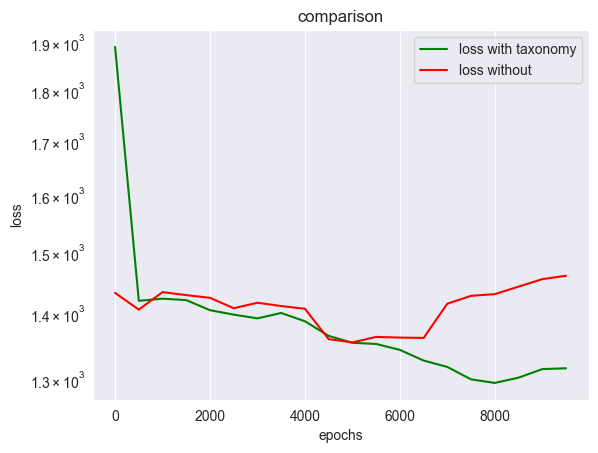

In [28]:
make_graph(loss_1, loss_2, 'graphs_2/ShiftTemp_TaxonomyTraffic')

In [29]:
calculate_mean_difference(y_test, pred_1)

1290.571802922462


In [30]:
calculate_mean_difference(y_test, pred_2)

1352.0141145904795


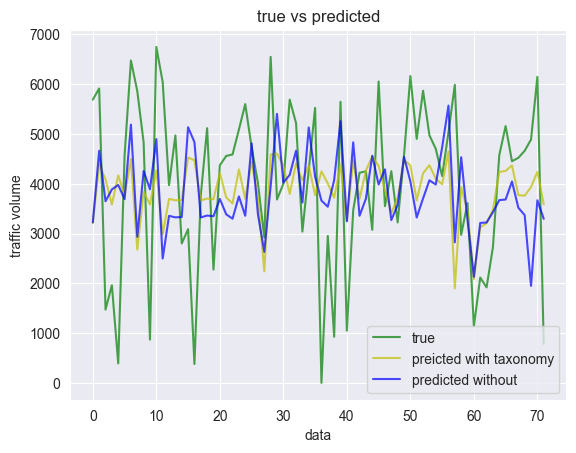

In [31]:
make_graph_predicted(y_test.cpu().detach().numpy(), pred_1.cpu().detach().numpy(), pred_2.cpu().detach().numpy(), 'graphs_2/ShiftTemp_TaxonomyTraffic_true_vs_pred')

In [32]:
del shift_temp
del shift_temp_train
del shift_temp_test
del traffic_train
del X_train
del y_train
del X_test
del y_test
del model
del model_wout

### shift year

In [33]:
shift_year = df.copy()
shift_year = shift_year.drop(['weather_1', 'weather_2'], axis = 1)

shift_year_train = shift_year.loc[shift_year['year'] < 2018]
shift_year_test = shift_year.loc[shift_year['year'] >= 2018]

shift_year_train = shift_year_train.drop('year', axis=1)
shift_year_test = shift_year_test.drop('year', axis=1)

In [34]:
shift_year_train.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,traffic_1,traffic_2
0,0,288.28,0.0,0.0,40,0,0,5545,2,4
1,0,289.36,0.0,0.0,75,0,1,4516,1,3
2,0,289.58,0.0,0.0,90,0,2,4767,1,3
3,0,290.13,0.0,0.0,90,0,2,5026,2,4
4,0,291.14,0.0,0.0,75,0,1,4918,2,4


In [35]:
traffic_train = shift_year_train[['traffic_1', 'traffic_2']]
traffic_1 = traffic_train['traffic_1'].iloc[:].values
traffic_2 = traffic_train['traffic_2'].iloc[:].values

traffic_1 = torch.tensor(traffic_1, dtype=torch.float32).view(-1, 1).to(device)
traffic_2 = torch.tensor(traffic_2, dtype=torch.float32).view(-1, 1).to(device)

traffic_1 = traffic_1.flatten(end_dim=1).type(torch.LongTensor).to(device)
traffic_2 = traffic_2.flatten(end_dim=1).type(torch.LongTensor).to(device)

In [36]:
shift_year_train = shift_year_train.drop(['traffic_1', 'traffic_2'], axis=1)
shift_year_test = shift_year_test.drop(['traffic_1', 'traffic_2'], axis=1)
shift_year_train.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
0,0,288.28,0.0,0.0,40,0,0,5545
1,0,289.36,0.0,0.0,75,0,1,4516
2,0,289.58,0.0,0.0,90,0,2,4767
3,0,290.13,0.0,0.0,90,0,2,5026
4,0,291.14,0.0,0.0,75,0,1,4918


In [37]:
X_train = shift_year_train.drop('traffic_volume', axis=1)
y_train = shift_year_train.traffic_volume
X_test = shift_year_test.drop('traffic_volume', axis=1)
y_test = shift_year_test.traffic_volume

In [38]:
X_train = X_train.iloc[:, :].values
y_train = y_train.iloc[:].values
X_test = X_test.iloc[:, :].values
y_test = y_test.iloc[:].values

In [39]:
scaler = TorchStandardScaler()
scaler.fit(X_train)

In [40]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [41]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

In [42]:
input_dim = X_train.shape[1]
model = RegressionModelTraffic(input_dim).to(device)
model_wout = RegressionModelTraffic(input_dim).to(device)

In [43]:
%%time
pred_1, loss_1 = trainModelTraffic(model, True, 10000, 'models_2/bestModel_ShYear_TaxTr')

epoch    500/ 10000 | training Loss: 1724.31 | test Loss:    1686.89
epoch   1000/ 10000 | training Loss: 1685.46 | test Loss:    1649.37
epoch   1500/ 10000 | training Loss: 1679.68 | test Loss:    1643.45
epoch   2000/ 10000 | training Loss: 1676.23 | test Loss:    1639.38
epoch   2500/ 10000 | training Loss: 1673.26 | test Loss:    1636.24
epoch   3000/ 10000 | training Loss: 1670.51 | test Loss:    1634.00
epoch   3500/ 10000 | training Loss: 1668.35 | test Loss:    1631.98
epoch   4000/ 10000 | training Loss: 1666.47 | test Loss:    1629.83
epoch   4500/ 10000 | training Loss: 1663.98 | test Loss:    1628.34
epoch   5000/ 10000 | training Loss: 1661.57 | test Loss:    1625.54
epoch   5500/ 10000 | training Loss: 1660.01 | test Loss:    1623.07
epoch   6000/ 10000 | training Loss: 1659.11 | test Loss:    1621.44
epoch   6500/ 10000 | training Loss: 1658.20 | test Loss:    1620.08
epoch   7000/ 10000 | training Loss: 1657.34 | test Loss:    1619.13
epoch   7500/ 10000 | training Los

In [44]:
%%time
pred_2, loss_2 = trainModelTraffic(model_wout, False, 10000, 'models_2/bestModel_ShYear_TaxTr___old')

epoch    500/ 10000 | training Loss: 1690.55 | test Loss:    1653.84
epoch   1000/ 10000 | training Loss: 1671.96 | test Loss:    1632.62
epoch   1500/ 10000 | training Loss: 1661.31 | test Loss:    1619.06
epoch   2000/ 10000 | training Loss: 1653.40 | test Loss:    1611.41
epoch   2500/ 10000 | training Loss: 1648.55 | test Loss:    1608.45
epoch   3000/ 10000 | training Loss: 1643.93 | test Loss:    1606.36
epoch   3500/ 10000 | training Loss: 1639.11 | test Loss:    1603.63
epoch   4000/ 10000 | training Loss: 1634.52 | test Loss:    1603.24
epoch   4500/ 10000 | training Loss: 1630.40 | test Loss:    1602.42
epoch   5000/ 10000 | training Loss: 1626.94 | test Loss:    1599.54
epoch   5500/ 10000 | training Loss: 1624.34 | test Loss:    1597.24
epoch   6000/ 10000 | training Loss: 1622.36 | test Loss:    1595.82
epoch   6500/ 10000 | training Loss: 1620.78 | test Loss:    1595.79
epoch   7000/ 10000 | training Loss: 1619.68 | test Loss:    1596.15
epoch   7500/ 10000 | training Los

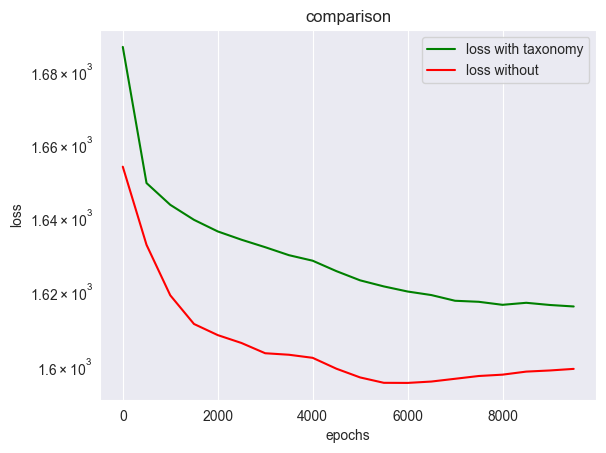

In [45]:
make_graph(loss_1, loss_2, 'graphs_2/ShiftYear_TaxonomyTraffic')

In [46]:
calculate_mean_difference(y_test, pred_1)

1616.0429669954983


In [47]:
calculate_mean_difference(y_test, pred_2)

1596.0889054698034


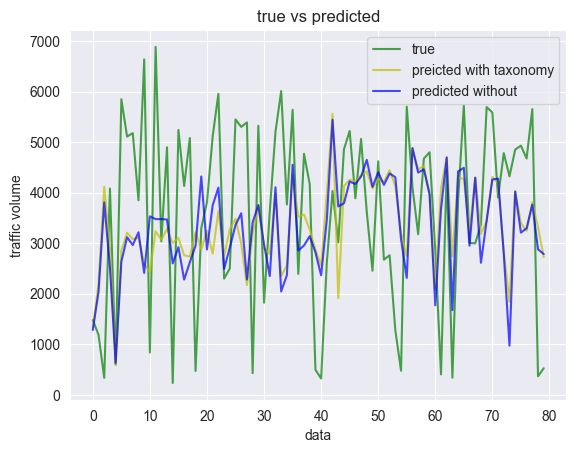

In [48]:
make_graph_predicted(y_test.cpu().detach().numpy(), pred_1.cpu().detach().numpy(), pred_2.cpu().detach().numpy(), 'graphs_2/ShiftYear_TaxonomyTraffic_true_vs_pred')

In [49]:
del shift_year
del shift_year_train
del shift_year_test
del traffic_train
del X_train
del y_train
del X_test
del y_test
del model
del model_wout

### shift rain

In [50]:
shift_rain = df.copy()
shift_rain = shift_rain.drop(['weather_1', 'weather_2'], axis = 1)

shift_rain_train = shift_rain.loc[shift_rain['rain_1h'] <= 0]
shift_rain_test = shift_rain.loc[shift_rain['rain_1h'] > 0]

shift_rain_train = shift_rain_train.drop('year', axis=1)
shift_rain_test = shift_rain_test.drop('year', axis=1)

In [51]:
shift_rain_train.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,traffic_1,traffic_2
0,0,288.28,0.0,0.0,40,0,0,5545,2,4
1,0,289.36,0.0,0.0,75,0,1,4516,1,3
2,0,289.58,0.0,0.0,90,0,2,4767,1,3
3,0,290.13,0.0,0.0,90,0,2,5026,2,4
4,0,291.14,0.0,0.0,75,0,1,4918,2,4


In [52]:
traffic_train = shift_rain_train[['traffic_1', 'traffic_2']]
traffic_1 = traffic_train['traffic_1'].iloc[:].values
traffic_2 = traffic_train['traffic_2'].iloc[:].values

traffic_1 = torch.tensor(traffic_1, dtype=torch.float32).view(-1, 1).to(device)
traffic_2 = torch.tensor(traffic_2, dtype=torch.float32).view(-1, 1).to(device)

traffic_1 = traffic_1.flatten(end_dim=1).type(torch.LongTensor).to(device)
traffic_2 = traffic_2.flatten(end_dim=1).type(torch.LongTensor).to(device)

In [53]:
shift_rain_train = shift_rain_train.drop(['traffic_1', 'traffic_2'], axis=1)
shift_rain_test = shift_rain_test.drop(['traffic_1', 'traffic_2'], axis=1)
shift_rain_train.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
0,0,288.28,0.0,0.0,40,0,0,5545
1,0,289.36,0.0,0.0,75,0,1,4516
2,0,289.58,0.0,0.0,90,0,2,4767
3,0,290.13,0.0,0.0,90,0,2,5026
4,0,291.14,0.0,0.0,75,0,1,4918


In [54]:
X_train = shift_rain_train.drop('traffic_volume', axis=1)
y_train = shift_rain_train.traffic_volume
X_test = shift_rain_test.drop('traffic_volume', axis=1)
y_test = shift_rain_test.traffic_volume

In [55]:
X_train = X_train.iloc[:, :].values
y_train = y_train.iloc[:].values
X_test = X_test.iloc[:, :].values
y_test = y_test.iloc[:].values

In [56]:
scaler = TorchStandardScaler()
scaler.fit(X_train)

In [57]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [58]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

In [59]:
input_dim = X_train.shape[1]
model = RegressionModelTraffic(input_dim).to(device)
model_wout = RegressionModelTraffic(input_dim).to(device)

In [60]:
%%time
pred_1, loss_1 = trainModelTraffic(model, True, 10000, 'models_2/bestModel_ShRain_TaxTr')

epoch    500/ 10000 | training Loss: 1812.31 | test Loss: 11158910976.00
epoch   1000/ 10000 | training Loss: 1671.21 | test Loss: 14347490304.00
epoch   1500/ 10000 | training Loss: 1665.45 | test Loss: 15064962048.00
epoch   2000/ 10000 | training Loss: 1661.98 | test Loss: 16054310912.00
epoch   2500/ 10000 | training Loss: 1658.83 | test Loss: 17301489664.00
epoch   3000/ 10000 | training Loss: 1655.34 | test Loss: 18733742080.00
epoch   3500/ 10000 | training Loss: 1652.38 | test Loss: 20243367936.00
epoch   4000/ 10000 | training Loss: 1649.12 | test Loss: 21883875328.00
epoch   4500/ 10000 | training Loss: 1646.62 | test Loss: 23524497408.00
epoch   5000/ 10000 | training Loss: 1644.80 | test Loss: 25157050368.00
epoch   5500/ 10000 | training Loss: 1643.13 | test Loss: 26875056128.00
epoch   6000/ 10000 | training Loss: 1641.82 | test Loss: 28523819008.00
epoch   6500/ 10000 | training Loss: 1640.90 | test Loss: 30293825536.00
epoch   7000/ 10000 | training Loss: 1640.11 | test

In [61]:
%%time
pred_2, loss_2 = trainModelTraffic(model_wout, False, 10000, 'models_2/bestModel_ShRain_TaxTr___old')

epoch    500/ 10000 | training Loss: 1674.94 | test Loss: 20578340864.00
epoch   1000/ 10000 | training Loss: 1662.79 | test Loss: 19461036032.00
epoch   1500/ 10000 | training Loss: 1653.78 | test Loss: 18119251968.00
epoch   2000/ 10000 | training Loss: 1642.08 | test Loss: 16895390720.00
epoch   2500/ 10000 | training Loss: 1635.82 | test Loss: 15247940608.00
epoch   3000/ 10000 | training Loss: 1630.83 | test Loss: 12731019264.00
epoch   3500/ 10000 | training Loss: 1625.83 | test Loss: 10618552320.00
epoch   4000/ 10000 | training Loss: 1619.86 | test Loss: 9256269824.00
epoch   4500/ 10000 | training Loss: 1614.95 | test Loss: 7787980288.00
epoch   5000/ 10000 | training Loss: 1611.32 | test Loss: 6796370432.00
epoch   5500/ 10000 | training Loss: 1609.00 | test Loss: 6977876480.00
epoch   6000/ 10000 | training Loss: 1606.52 | test Loss: 6334295552.00
epoch   6500/ 10000 | training Loss: 1604.54 | test Loss: 6409163776.00
epoch   7000/ 10000 | training Loss: 1603.15 | test Loss:

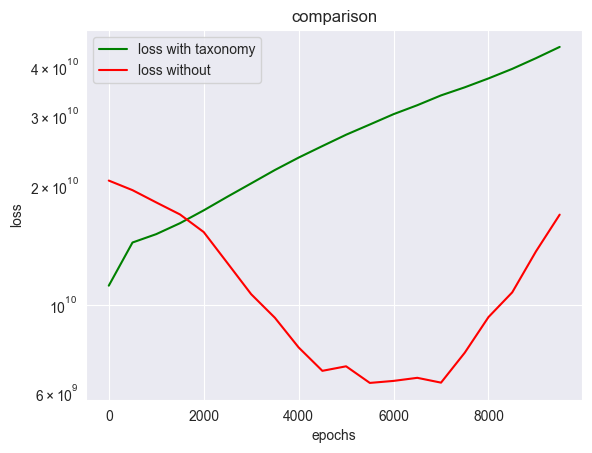

In [62]:
make_graph(loss_1, loss_2, 'graphs_2/ShiftRain_TaxonomyTraffic')

In [63]:
calculate_mean_difference(y_test, pred_1)

45673.59583008939


In [64]:
calculate_mean_difference(y_test, pred_2)

194545.40324820403


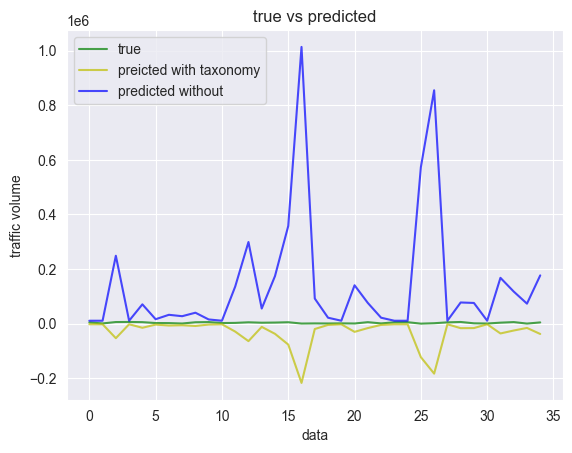

In [65]:
make_graph_predicted(y_test.cpu().detach().numpy(), pred_1.cpu().detach().numpy(), pred_2.cpu().detach().numpy(), 'graphs_2/ShiftRain_TaxonomyTraffic_true_vs_pred')

In [66]:
del shift_rain
del shift_rain_train
del shift_rain_test
del traffic_train
del X_train
del y_train
del X_test
del y_test
del model
del model_wout

## taxonomy weather

### model + some functions

In [67]:
class RegressionModelWeather(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModelWeather, self).__init__()
        self.hidden1 = nn.Linear(input_dim, 64)
        
        self.hidden2 = nn.Linear(64, 32)
        self.hidden2_out = nn.Linear(32, 2)
        
        self.hidden3 = nn.Linear(32, 16)
        
        self.hidden4 = nn.Linear(16, 8)
        self.hidden4_out = nn.Linear(8, 5)
        
        self.output = nn.Linear(8, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        
        x = self.relu(self.hidden2(x))
        x2_out = self.hidden2_out(x)
        
        x = self.relu(self.hidden3(x))
        
        x = self.relu(self.hidden4(x))
        x4_out = self.hidden4_out(x)
        
        output = self.output(x)
        return output, x2_out, x4_out

In [68]:
def trainModelWeather(model, tax, num_epochs=1000, save_path='bestModel'):
    loss_val = []
    accuracy = []
    total_accu = None
    total_acc, total_count = 0, 0
    
    criterion_regression = nn.HuberLoss()
    criterion_classification = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_loss = float('inf')
    best_model_wts = model.state_dict()

    for epoch in range(num_epochs):
        model.train()
        
        outputs, x2_out, x4_out = model(X_train)
        loss = criterion_regression(outputs, y_train)

        loss_1 = criterion_classification(x2_out, weather_1)*100
        loss_2 = criterion_classification(x4_out, weather_2)*100

        if tax:
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
            
            optimizer.zero_grad()
            loss_1.backward(retain_graph=True)
            optimizer.step()
            
            optimizer.zero_grad()
            loss_2.backward(retain_graph=True)
            optimizer.step()
        else:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()        


        model.eval()
        with torch.no_grad():
            predictions, _, _ = model(X_test)
            test_loss = criterion_regression(predictions, y_test)
        
        if test_loss < best_loss:
            best_loss = test_loss
            torch.save(model.state_dict(), save_path)
            #best_model_wts = model.state_dict()

        if (epoch+1) % 500 == 0:
            print(f'epoch {(epoch+1):6d}/{num_epochs:6d} | training Loss: {loss.item():.2f} | test Loss: {test_loss.item():10.2f}')
            loss_val.append(test_loss.cpu())
    
    model.load_state_dict(torch.load(save_path))
    model.eval()
    predictions, _, _ = model(X_test)
    loss = criterion_regression(predictions, y_test)
    print(f'\nBest loss: {loss.item():.2f}')
    
    return predictions, loss_val

### shift temp

In [69]:
shift_temp = df.copy()
shift_temp = shift_temp.drop(['year', 'traffic_1', 'traffic_2'], axis = 1)

shift_temp_train = shift_temp.loc[shift_temp['temp'] <= 295]
shift_temp_test = shift_temp.loc[shift_temp['temp'] > 295]

In [70]:
shift_temp_train.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,weather_1,weather_2
0,0,288.28,0.0,0.0,40,0,0,5545,0,1
1,0,289.36,0.0,0.0,75,0,1,4516,0,1
2,0,289.58,0.0,0.0,90,0,2,4767,0,1
3,0,290.13,0.0,0.0,90,0,2,5026,0,1
4,0,291.14,0.0,0.0,75,0,1,4918,0,1


In [71]:
weather_train = shift_temp_train[['weather_1', 'weather_2']]
weather_1 = weather_train['weather_1'].iloc[:].values
weather_2 = weather_train['weather_2'].iloc[:].values

weather_1 = torch.tensor(weather_1, dtype=torch.float32).view(-1, 1).to(device)
weather_2 = torch.tensor(weather_2, dtype=torch.float32).view(-1, 1).to(device)

weather_1 = weather_1.flatten(end_dim=1).type(torch.LongTensor).to(device)
weather_2 = weather_2.flatten(end_dim=1).type(torch.LongTensor).to(device)

In [72]:
shift_temp_train = shift_temp_train.drop(['weather_1', 'weather_2'], axis=1)
shift_temp_test = shift_temp_test.drop(['weather_1', 'weather_2'], axis=1)
shift_temp_train.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
0,0,288.28,0.0,0.0,40,0,0,5545
1,0,289.36,0.0,0.0,75,0,1,4516
2,0,289.58,0.0,0.0,90,0,2,4767
3,0,290.13,0.0,0.0,90,0,2,5026
4,0,291.14,0.0,0.0,75,0,1,4918


In [73]:
X_train = shift_temp_train.drop('traffic_volume', axis=1)
y_train = shift_temp_train.traffic_volume
X_test = shift_temp_test.drop('traffic_volume', axis=1)
y_test = shift_temp_test.traffic_volume

data standardization

In [74]:
X_train = X_train.iloc[:, :].values
y_train = y_train.iloc[:].values
X_test = X_test.iloc[:, :].values
y_test = y_test.iloc[:].values

In [75]:
scaler = TorchStandardScaler()
scaler.fit(X_train)

In [76]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

converting data to tensors

In [77]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

training

In [78]:
input_dim = X_train.shape[1]
model = RegressionModelWeather(input_dim).to(device)
model_wout = RegressionModelWeather(input_dim).to(device)

In [79]:
%%time
pred_1, loss_1 = trainModelWeather(model, True, 10000, 'models_2/bestModel_ShT_TaxWe')

epoch    500/ 10000 | training Loss: 1750.44 | test Loss:    1521.38
epoch   1000/ 10000 | training Loss: 1736.28 | test Loss:    1403.71
epoch   1500/ 10000 | training Loss: 1731.29 | test Loss:    1415.40
epoch   2000/ 10000 | training Loss: 1725.91 | test Loss:    1456.05
epoch   2500/ 10000 | training Loss: 1719.61 | test Loss:    1448.06
epoch   3000/ 10000 | training Loss: 1712.59 | test Loss:    1473.17
epoch   3500/ 10000 | training Loss: 1709.34 | test Loss:    1475.17
epoch   4000/ 10000 | training Loss: 1708.13 | test Loss:    1466.03
epoch   4500/ 10000 | training Loss: 1706.60 | test Loss:    1461.11
epoch   5000/ 10000 | training Loss: 1704.05 | test Loss:    1455.47
epoch   5500/ 10000 | training Loss: 1699.02 | test Loss:    1437.95
epoch   6000/ 10000 | training Loss: 1694.01 | test Loss:    1405.35
epoch   6500/ 10000 | training Loss: 1689.55 | test Loss:    1386.16
epoch   7000/ 10000 | training Loss: 1686.82 | test Loss:    1355.58
epoch   7500/ 10000 | training Los

In [80]:
%%time
pred_2, loss_2 = trainModelWeather(model_wout, False, 10000, 'models_2/bestModel_ShT_TaxWe___old')

epoch    500/ 10000 | training Loss: 1757.44 | test Loss:    1492.97
epoch   1000/ 10000 | training Loss: 1733.24 | test Loss:    1413.62
epoch   1500/ 10000 | training Loss: 1720.58 | test Loss:    1462.92
epoch   2000/ 10000 | training Loss: 1715.83 | test Loss:    1455.86
epoch   2500/ 10000 | training Loss: 1712.20 | test Loss:    1449.15
epoch   3000/ 10000 | training Loss: 1707.71 | test Loss:    1440.75
epoch   3500/ 10000 | training Loss: 1703.39 | test Loss:    1428.37
epoch   4000/ 10000 | training Loss: 1699.11 | test Loss:    1411.69
epoch   4500/ 10000 | training Loss: 1695.27 | test Loss:    1392.73
epoch   5000/ 10000 | training Loss: 1691.96 | test Loss:    1388.95
epoch   5500/ 10000 | training Loss: 1688.75 | test Loss:    1381.13
epoch   6000/ 10000 | training Loss: 1686.08 | test Loss:    1385.34
epoch   6500/ 10000 | training Loss: 1683.65 | test Loss:    1428.97
epoch   7000/ 10000 | training Loss: 1681.56 | test Loss:    1489.26
epoch   7500/ 10000 | training Los

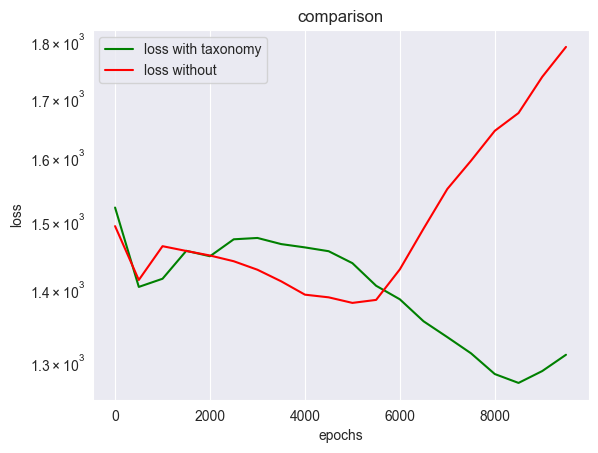

In [81]:
make_graph(loss_1, loss_2, 'graphs_2/ShiftTemp_TaxonomyWeather')

In [82]:
calculate_mean_difference(y_test, pred_1)

1272.9065275826442


In [83]:
calculate_mean_difference(y_test, pred_2)

1375.2015328633506


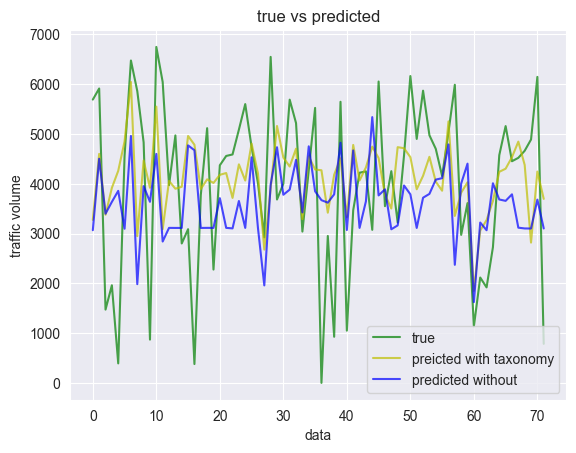

In [84]:
make_graph_predicted(y_test.cpu().detach().numpy(), pred_1.cpu().detach().numpy(), pred_2.cpu().detach().numpy(), 'graphs_2/ShiftTemp_TaxonomyWeather_true_vs_pred')

In [85]:
del shift_temp
del shift_temp_train
del shift_temp_test
del weather_train
del X_train
del y_train
del X_test
del y_test
del model
del model_wout

### shift year

In [86]:
shift_year = df.copy()
shift_year = shift_year.drop(['traffic_1', 'traffic_2'], axis = 1)

shift_year_train = shift_year.loc[shift_year['year'] < 2018]
shift_year_test = shift_year.loc[shift_year['year'] >= 2018]

shift_year_train = shift_year_train.drop('year', axis=1)
shift_year_test = shift_year_test.drop('year', axis=1)

In [87]:
shift_year_train.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,weather_1,weather_2
0,0,288.28,0.0,0.0,40,0,0,5545,0,1
1,0,289.36,0.0,0.0,75,0,1,4516,0,1
2,0,289.58,0.0,0.0,90,0,2,4767,0,1
3,0,290.13,0.0,0.0,90,0,2,5026,0,1
4,0,291.14,0.0,0.0,75,0,1,4918,0,1


In [88]:
weather_train = shift_year_train[['weather_1', 'weather_2']]
weather_1 = weather_train['weather_1'].iloc[:].values
weather_2 = weather_train['weather_2'].iloc[:].values

weather_1 = torch.tensor(weather_1, dtype=torch.float32).view(-1, 1).to(device)
weather_2 = torch.tensor(weather_2, dtype=torch.float32).view(-1, 1).to(device)

weather_1 = weather_1.flatten(end_dim=1).type(torch.LongTensor).to(device)
weather_2 = weather_2.flatten(end_dim=1).type(torch.LongTensor).to(device)

In [89]:
shift_year_train = shift_year_train.drop(['weather_1', 'weather_2'], axis=1)
shift_year_test = shift_year_test.drop(['weather_1', 'weather_2'], axis=1)
shift_year_train.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
0,0,288.28,0.0,0.0,40,0,0,5545
1,0,289.36,0.0,0.0,75,0,1,4516
2,0,289.58,0.0,0.0,90,0,2,4767
3,0,290.13,0.0,0.0,90,0,2,5026
4,0,291.14,0.0,0.0,75,0,1,4918


In [90]:
X_train = shift_year_train.drop('traffic_volume', axis=1)
y_train = shift_year_train.traffic_volume
X_test = shift_year_test.drop('traffic_volume', axis=1)
y_test = shift_year_test.traffic_volume

In [91]:
X_train = X_train.iloc[:, :].values
y_train = y_train.iloc[:].values
X_test = X_test.iloc[:, :].values
y_test = y_test.iloc[:].values

In [92]:
scaler = TorchStandardScaler()
scaler.fit(X_train)

In [93]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [94]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

In [95]:
input_dim = X_train.shape[1]
model = RegressionModelWeather(input_dim).to(device)
model_wout = RegressionModelWeather(input_dim).to(device)

In [96]:
%%time
pred_1, loss_1 = trainModelWeather(model, True, 10000, 'models_2/bestModel_ShYear_TaxWe')

epoch    500/ 10000 | training Loss: 1691.42 | test Loss:    1659.19
epoch   1000/ 10000 | training Loss: 1681.21 | test Loss:    1645.48
epoch   1500/ 10000 | training Loss: 1676.85 | test Loss:    1637.71
epoch   2000/ 10000 | training Loss: 1673.54 | test Loss:    1633.58
epoch   2500/ 10000 | training Loss: 1668.88 | test Loss:    1629.65
epoch   3000/ 10000 | training Loss: 1666.77 | test Loss:    1630.37
epoch   3500/ 10000 | training Loss: 1665.41 | test Loss:    1629.67
epoch   4000/ 10000 | training Loss: 1664.70 | test Loss:    1629.07
epoch   4500/ 10000 | training Loss: 1663.94 | test Loss:    1628.75
epoch   5000/ 10000 | training Loss: 1662.91 | test Loss:    1629.43
epoch   5500/ 10000 | training Loss: 1661.14 | test Loss:    1628.90
epoch   6000/ 10000 | training Loss: 1657.94 | test Loss:    1627.53
epoch   6500/ 10000 | training Loss: 1657.87 | test Loss:    1629.66
epoch   7000/ 10000 | training Loss: 1656.75 | test Loss:    1626.85
epoch   7500/ 10000 | training Los

In [97]:
%%time
pred_2, loss_2 = trainModelWeather(model_wout, False, 10000, 'models_2/bestModel_ShYear_TaxWe___old')

epoch    500/ 10000 | training Loss: 1695.34 | test Loss:    1662.51
epoch   1000/ 10000 | training Loss: 1679.04 | test Loss:    1637.49
epoch   1500/ 10000 | training Loss: 1669.50 | test Loss:    1627.36
epoch   2000/ 10000 | training Loss: 1659.73 | test Loss:    1618.95
epoch   2500/ 10000 | training Loss: 1654.60 | test Loss:    1614.01
epoch   3000/ 10000 | training Loss: 1649.58 | test Loss:    1611.49
epoch   3500/ 10000 | training Loss: 1644.82 | test Loss:    1609.68
epoch   4000/ 10000 | training Loss: 1640.51 | test Loss:    1608.47
epoch   4500/ 10000 | training Loss: 1636.65 | test Loss:    1608.23
epoch   5000/ 10000 | training Loss: 1633.82 | test Loss:    1606.26
epoch   5500/ 10000 | training Loss: 1631.49 | test Loss:    1606.21
epoch   6000/ 10000 | training Loss: 1630.30 | test Loss:    1605.21
epoch   6500/ 10000 | training Loss: 1629.62 | test Loss:    1605.42
epoch   7000/ 10000 | training Loss: 1628.67 | test Loss:    1605.63
epoch   7500/ 10000 | training Los

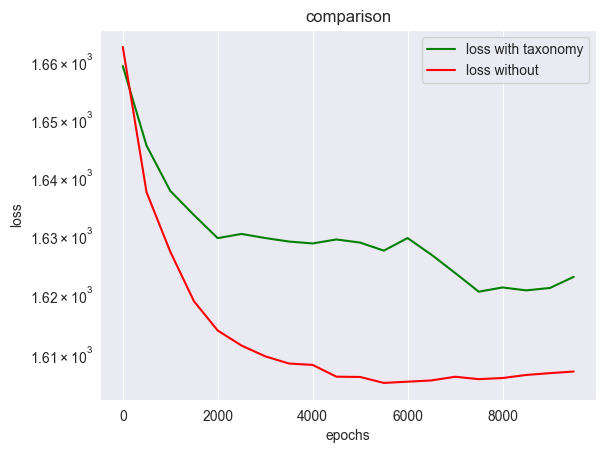

In [98]:
make_graph(loss_1, loss_2, 'graphs_2/ShiftYear_TaxonomyWeather')

In [99]:
calculate_mean_difference(y_test, pred_1)

1617.1451003469956


In [100]:
calculate_mean_difference(y_test, pred_2)

1605.1130039466075


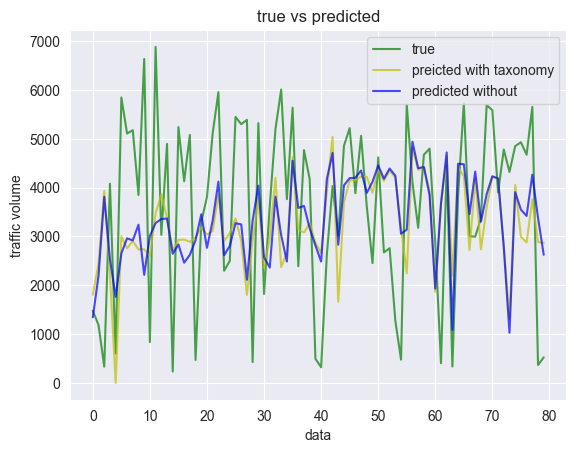

In [101]:
make_graph_predicted(y_test.cpu().detach().numpy(), pred_1.cpu().detach().numpy(), pred_2.cpu().detach().numpy(), 'graphs_2/ShiftYear_TaxonomyWeather_true_vs_pred')

In [102]:
del shift_year
del shift_year_train
del shift_year_test
del weather_train
del X_train
del y_train
del X_test
del y_test
del model
del model_wout

### shift rain

In [103]:
shift_rain = df.copy()
shift_rain = shift_rain.drop(['traffic_1', 'traffic_2'], axis = 1)

shift_rain_train = shift_rain.loc[shift_rain['rain_1h'] <= 0]
shift_rain_test = shift_rain.loc[shift_rain['rain_1h'] > 0]

shift_rain_train = shift_rain_train.drop('year', axis=1)
shift_rain_test = shift_rain_test.drop('year', axis=1)

In [104]:
shift_rain_train.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,weather_1,weather_2
0,0,288.28,0.0,0.0,40,0,0,5545,0,1
1,0,289.36,0.0,0.0,75,0,1,4516,0,1
2,0,289.58,0.0,0.0,90,0,2,4767,0,1
3,0,290.13,0.0,0.0,90,0,2,5026,0,1
4,0,291.14,0.0,0.0,75,0,1,4918,0,1


In [105]:
weather_train = shift_rain_train[['weather_1', 'weather_2']]
weather_1 = weather_train['weather_1'].iloc[:].values
weather_2 = weather_train['weather_2'].iloc[:].values

weather_1 = torch.tensor(weather_1, dtype=torch.float32).view(-1, 1).to(device)
weather_2 = torch.tensor(weather_2, dtype=torch.float32).view(-1, 1).to(device)

weather_1 = weather_1.flatten(end_dim=1).type(torch.LongTensor).to(device)
weather_2 = weather_2.flatten(end_dim=1).type(torch.LongTensor).to(device)

In [106]:
shift_rain_train = shift_rain_train.drop(['weather_1', 'weather_2'], axis=1)
shift_rain_test = shift_rain_test.drop(['weather_1', 'weather_2'], axis=1)
shift_rain_train.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
0,0,288.28,0.0,0.0,40,0,0,5545
1,0,289.36,0.0,0.0,75,0,1,4516
2,0,289.58,0.0,0.0,90,0,2,4767
3,0,290.13,0.0,0.0,90,0,2,5026
4,0,291.14,0.0,0.0,75,0,1,4918


In [107]:
X_train = shift_rain_train.drop('traffic_volume', axis=1)
y_train = shift_rain_train.traffic_volume
X_test = shift_rain_test.drop('traffic_volume', axis=1)
y_test = shift_rain_test.traffic_volume

In [108]:
X_train = X_train.iloc[:, :].values
y_train = y_train.iloc[:].values
X_test = X_test.iloc[:, :].values
y_test = y_test.iloc[:].values

In [109]:
scaler = TorchStandardScaler()
scaler.fit(X_train)

In [110]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [111]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

In [112]:
input_dim = X_train.shape[1]
model = RegressionModelWeather(input_dim).to(device)
model_wout = RegressionModelWeather(input_dim).to(device)

In [113]:
%%time
pred_1, loss_1 = trainModelWeather(model, True, 10000, 'models_2/bestModel_ShRain_TaxWe')

epoch    500/ 10000 | training Loss: 1686.31 | test Loss: 16401784832.00
epoch   1000/ 10000 | training Loss: 1665.39 | test Loss: 16520796160.00
epoch   1500/ 10000 | training Loss: 1654.86 | test Loss: 16956112896.00
epoch   2000/ 10000 | training Loss: 1645.58 | test Loss: 18435956736.00
epoch   2500/ 10000 | training Loss: 1638.96 | test Loss: 18758166528.00
epoch   3000/ 10000 | training Loss: 1637.09 | test Loss: 20018317312.00
epoch   3500/ 10000 | training Loss: 1636.10 | test Loss: 20164231168.00
epoch   4000/ 10000 | training Loss: 1635.02 | test Loss: 20364673024.00
epoch   4500/ 10000 | training Loss: 1633.46 | test Loss: 20703635456.00
epoch   5000/ 10000 | training Loss: 1631.39 | test Loss: 20780855296.00
epoch   5500/ 10000 | training Loss: 1629.04 | test Loss: 20796884992.00
epoch   6000/ 10000 | training Loss: 1627.50 | test Loss: 21723760640.00
epoch   6500/ 10000 | training Loss: 1626.54 | test Loss: 22178400256.00
epoch   7000/ 10000 | training Loss: 1625.69 | test

In [114]:
%%time
pred_2, loss_2 = trainModelWeather(model_wout, False, 10000, 'models_2/bestModel_ShRain_TaxWe___old')

epoch    500/ 10000 | training Loss: 1676.43 | test Loss: 16066297856.00
epoch   1000/ 10000 | training Loss: 1657.22 | test Loss: 15770829824.00
epoch   1500/ 10000 | training Loss: 1642.87 | test Loss: 15755446272.00
epoch   2000/ 10000 | training Loss: 1635.58 | test Loss: 14553936896.00
epoch   2500/ 10000 | training Loss: 1630.88 | test Loss: 12861939712.00
epoch   3000/ 10000 | training Loss: 1627.29 | test Loss: 11035238400.00
epoch   3500/ 10000 | training Loss: 1623.23 | test Loss: 8115288576.00
epoch   4000/ 10000 | training Loss: 1618.62 | test Loss: 5113992704.00
epoch   4500/ 10000 | training Loss: 1614.58 | test Loss: 1617820032.00
epoch   5000/ 10000 | training Loss: 1611.83 | test Loss: 95123336.00
epoch   5500/ 10000 | training Loss: 1609.85 | test Loss:    3291.03
epoch   6000/ 10000 | training Loss: 1608.44 | test Loss:    3291.03
epoch   6500/ 10000 | training Loss: 1607.00 | test Loss:    3291.02
epoch   7000/ 10000 | training Loss: 1605.85 | test Loss:    3291.02


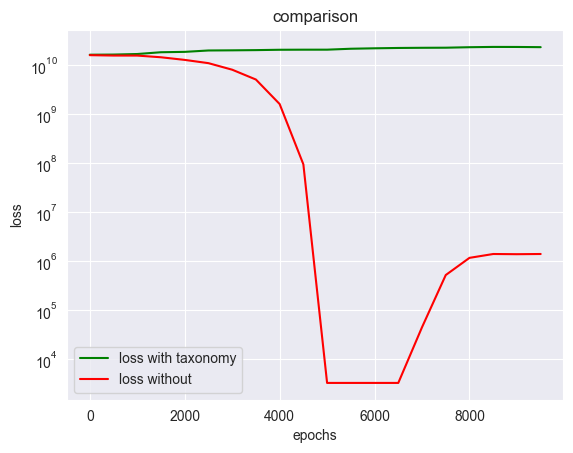

In [115]:
make_graph(loss_1, loss_2, 'graphs_2/ShiftRain_TaxonomyWeather')

In [116]:
calculate_mean_difference(y_test, pred_1)

8040.942592219245


In [117]:
calculate_mean_difference(y_test, pred_2)

3291.512810844912


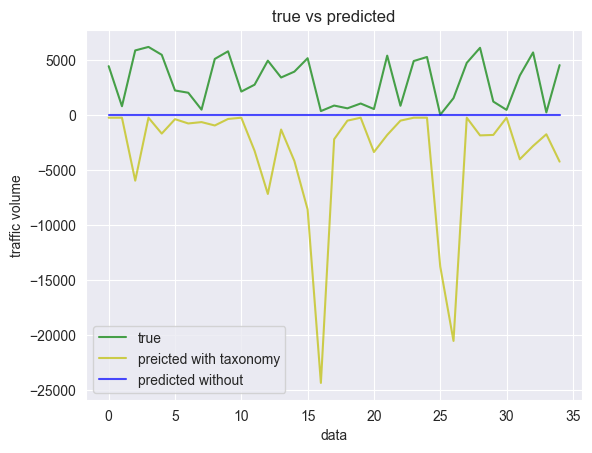

In [118]:
make_graph_predicted(y_test.cpu().detach().numpy(), pred_1.cpu().detach().numpy(), pred_2.cpu().detach().numpy(), 'graphs_2/ShiftRain_TaxonomyWeather_true_vs_pred')

In [119]:
pred_1

tensor([[-255.2565],
        [-255.2722],
        [-255.2565],
        ...,
        [-255.2575],
        [-255.2253],
        [-255.2497]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [120]:
pred_2

tensor([[0.3329],
        [0.3329],
        [0.3329],
        ...,
        [0.3329],
        [0.3329],
        [0.3329]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [121]:
del shift_rain
del shift_rain_train
del shift_rain_test
del weather_train
del X_train
del y_train
del X_test
del y_test
del model
del model_wout